### Качество предсказания при разбиении с учетом групп

<a href="https://pollytikhonova.github.io/coursework/validation/"><img src="https://pollytikhonova.github.io/coursework/GitHub-Mark-32px.png" alt="В репозиторий" title="В репозиторий" style="max-width:100%;  display: inline-block; margin-right: 10px;"></a> <a href="Train, Predict & Validate. Searching reasons of bad prediction-With Groups.ipynb" download target="_blank">Скачать этот ipunb-файл можно здесь</a>

In [1]:
import sys
sys.path.insert(0, '../basic codes')

import class_magnesium_not_drop_na
from class_magnesium_not_drop_na import *

from matplotlib.backends.backend_pdf import PdfPages

import sys
from IPython.core.display import clear_output
def change_output(x):
    clear_output()
    sys.stdout.write(x)
    sys.stdout.flush()

In [ ]:
import importlib
importlib.reload(class_magnesium_not_drop_na)
from class_magnesium_not_drop_na import *

In [6]:
class Magnesium_validation(Magnesium):    
    def __init__(self, validation_file, *args, **kwargs):
        change_output('Loading data...')
        super(Magnesium_validation, self).__init__(*args, **kwargs)
        change_output('Loading validation data...')
        self.validation_data = pd.read_table(validation_file).fillna(method = 'backfill', axis = 0)
        if np.sum(self.validation_data.isnull().any(axis=1)) > 0:
            self.validation_data.fillna(method = 'pad', axis = 0, inplace = True)
        self.validation_data = self.validation_data[~(self.validation_data['chainlen']>1000)]
        change_output('Data loaded')
        change_output('Data processing')
        self.x_test = np.matrix(self.validation_data[list(self.validation_data.columns)[2:-1]])
        self.y_test = np.array(self.validation_data[list(self.validation_data.columns)[-1]])
        self.data = self.data[~self.data['pdb_chain'].isin(self.validation_data['pdb_chain'])]        
        self.data_numpy = np.matrix(self.data)
        self.groups = self.data_numpy[:,:1]
        self.x = self.data_numpy[:, 1:-1]
        self.y = np.array(self.data_numpy[:,-1].flatten().tolist()[0])
        change_output("Data processed")
        
    def train(self, n_splits):
        self.trained_model_validation = self.model
        x = self.x
        y = self.y
        sss = StratifiedShuffleSplit(n_splits = n_splits, test_size = 0.3, random_state = 0)
        rus = RandomUnderSampler(ratio = 'auto', random_state=42)
        
        if self.with_groups:
            splitted = sss.split(x, y, groups = self.groups)
        else:            
            splitted = sss.split(x, y) 
        iterator = tqdm_notebook(splitted, desc = "Splits", leave = True) if tqdm else splitted            
        for train_index, test_index in iterator:               
            x_train, y_train = rus.fit_sample(x[train_index], y[train_index])
            self.trained_model_validation.fit(x_train, y_train)
        if not os.path.isdir('trained_models/with_groups'):
            os.mkdir('trained_models/with_groups')
        model_name = '%s_depth=%d_leaves=%d_%s_validation'%(re.split("\.|\'", str(self.trained_model_validation.__class__))[-2],
                                              self.trained_model_validation.__dict__['max_depth'], 
                                              self.trained_model_validation.__dict__['min_samples_leaf'],
                                              self.filename)
        with open("trained_models/with_groups"+model_name+".sav", 'wb') as file_to_save:
            pickle.dump(self.trained_model_validation, file_to_save)
            
            
    def compute_validated(self, n_splits = 3):
        self.train(n_splits)
        data = self.predict(x = self.x_test, y = self.y_test, model=self.trained_model_validation)
        self.show_plots(data['plots'])  
        self.validation_data['prediction'] = data['prediction']
        self.validation_data['probability'] = data['probability']
        return data        

In [3]:
#fold = 'https://tikhonovapolly.files.wordpress.com/2017/09/'
fold = '../A7_files/'
m = Magnesium_validation('data/set_val_A_7.csv', file_ = "set_minresol_a_7_1000.csv", fold = fold,
                        model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini',
                                                      max_depth = 39, min_samples_leaf = 1), with_groups = True)

Data processed

### Prediction on validation data

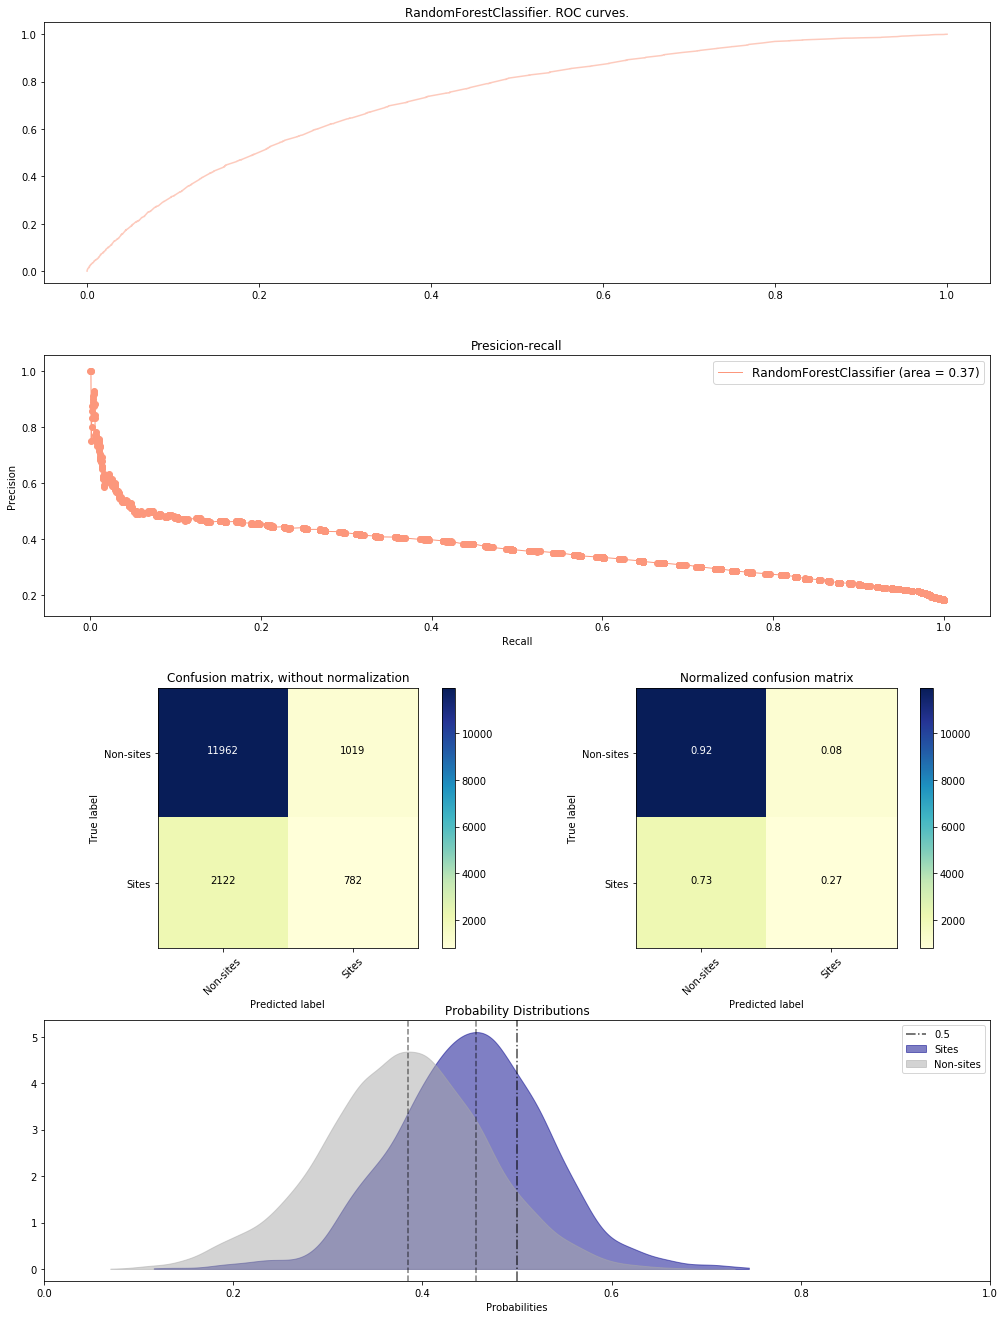

In [12]:
#os.mkdir('outputs/with_groups')
pdf_pages = PdfPages('outputs/with_groups/Predictions_A7_minresol.pdf')
data = m.compute_validated(n_splits = 5)
pdf_pages.savefig()
pdf_pages.close()

In [13]:
classifier = m.trained_model_validation
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
m.feature_inds = indices

with open('outputs/with_groups/Ranked features.txt', 'w') as file:
    for f in range(m.x.shape[1]):
        file.write("%s \t %f\n" % (m.features[indices[f]], importances[indices[f]]))

### Prediction on test split of training data

In [ ]:
pdf_pages = PdfPages('outputs/with_groups/Predictions_A7_minresol_not_validated.pdf')
data_nv = m.compute(n_splits = 5)
pdf_pages.savefig()
pdf_pages.close()

### Train & Predict on validation set


Portion of sites in test:  0.12158032596
Portion of sites in train:  0.5


/usr/lib64/python3.4/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib64/python3.4/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


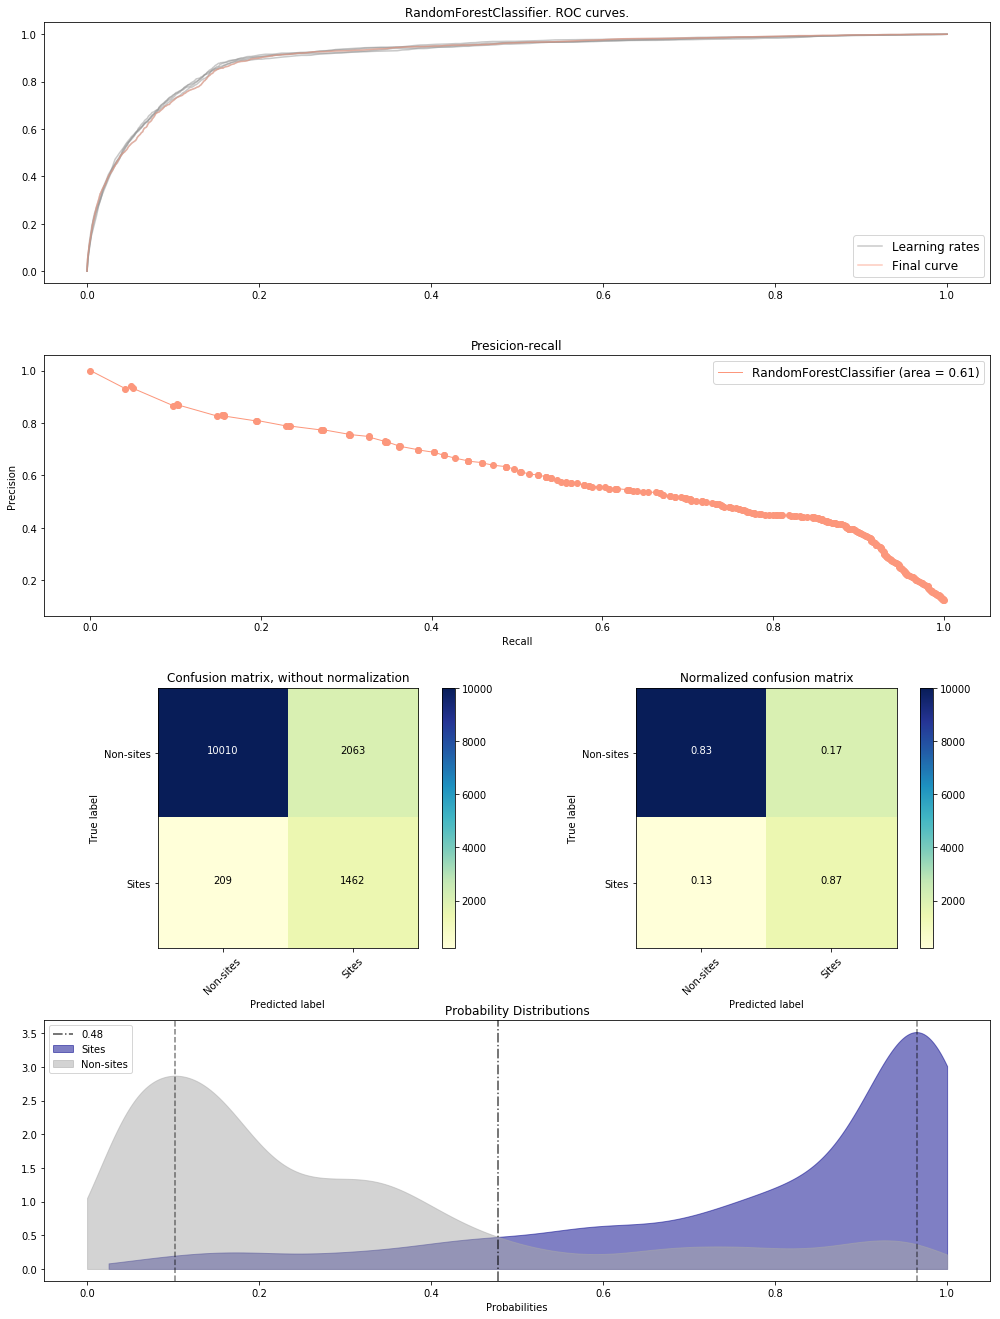

In [2]:
m_train = Magnesium(file_ = "set_val_A_7.csv", fold = 'data/',
                        model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini',
                                                      max_depth = 39, min_samples_leaf = 1))
m_train.compute(n_splits=5);

In [3]:
classifier = m_train.trained_model
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
m_train.feature_inds = indices

with open('outputs/with_groups/Ranked features on validation set.txt', 'w') as file:
    for f in range(m_train.x.shape[1]):
        file.write("%s \t %f\n" % (m_train.features[indices[f]], importances[indices[f]]))

### Compare importants

In [4]:
imps = pd.read_table('outputs/with_groups/Ranked features.txt', header=None)  
imps_validation = pd.read_table('outputs/with_groups/Ranked features on validation set.txt', header=None)  
imps_validation.sort_values(0,ascending=True, axis=0, inplace=True)
imps.sort_values(0,ascending=True, axis=0, inplace=True)
dif = np.abs(np.array(np.array(imps[1])-np.array(imps_validation[1])))
feature_imps = pd.DataFrame({'features':np.array(imps[0]), 
                             'usual':np.array(imps[1]), 
                             'validation':np.array(imps_validation[1]),
                            'difference':dif}, columns=['features', 'usual', 'validation', 'difference'])
feature_imps.sort_values('difference',ascending=False, axis=0, inplace=True)

In [5]:
feature_imps.head(50)

,features,usual,validation,difference
267,protein,0.000895,0.011628,0.010733
255,moietyP,0.012382,0.016694,0.004312
254,moietyB,0.012911,0.016902,0.003991
150,atomN,0.009815,0.013120,0.003305
268,resol,0.010433,0.013717,0.003284
158,atomO,0.009644,0.012734,0.003090
213,delta2,0.005746,0.008747,0.003001
212,delta1,0.005697,0.008355,0.002658
338,thetapm1,0.009134,0.006829,0.002305
214,deltam1,0.005843,0.008026,0.002183


### Better resolution

In [7]:
class Magnesium_validation(Magnesium):    
    def __init__(self, validation_file, *args, **kwargs):
        change_output('Loading data...')
        super(Magnesium_validation, self).__init__(*args, **kwargs)
        change_output('Loading validation data...')
        self.validation_data = pd.read_table(validation_file).fillna(method = 'backfill', axis = 0)
        if np.sum(self.validation_data.isnull().any(axis=1)) > 0:
            self.validation_data.fillna(method = 'pad', axis = 0, inplace = True)
        self.validation_data = self.validation_data[~(self.validation_data['chainlen']>1000)]
        self.validation_data = self.validation_data[self.validation_data['protein'] == 0]
        change_output('Data loaded')
        change_output('Data processing')
        self.x_test = np.matrix(self.validation_data[list(self.validation_data.columns)[2:-1]])
        self.y_test = np.array(self.validation_data[list(self.validation_data.columns)[-1]])
        self.data = self.data[~self.data['pdb_chain'].isin(self.validation_data['pdb_chain'])]
        self.data = self.data[(self.data['resol']<=3.5) & (self.data['protein'] == 0)]
        self.data_numpy = np.matrix(self.data)
        self.groups = self.data_numpy[:,:1]
        self.x = self.data_numpy[:, 1:-1]
        self.y = np.array(self.data_numpy[:,-1].flatten().tolist()[0])
        change_output("Data processed")
        
    def train(self, n_splits):
        self.trained_model_validation = self.model
        x = self.x
        y = self.y
        sss = StratifiedShuffleSplit(n_splits = n_splits, test_size = 0.3, random_state = 0)
        rus = RandomUnderSampler(ratio = 'auto', random_state=42)
        
        splitted = sss.split(x, y) 
        iterator = tqdm_notebook(splitted, desc = "Splits", leave = True) if tqdm else splitted            
        for train_index, test_index in iterator:               
            x_train, y_train = rus.fit_sample(x[train_index], y[train_index])
            self.trained_model_validation.fit(x_train, y_train)
        if not os.path.isdir('trained_models'):
            os.mkdir('trained_models')
        model_name = '%s_depth=%d_leaves=%d_%s_validation'%(re.split("\.|\'", str(self.trained_model_validation.__class__))[-2],
                                              self.trained_model_validation.__dict__['max_depth'], 
                                              self.trained_model_validation.__dict__['min_samples_leaf'],
                                              self.filename)
        with open("trained_models/"+model_name+".sav", 'wb') as file_to_save:
            pickle.dump(self.trained_model_validation, file_to_save)
            
            
    def compute_validated(self, n_splits = 3):
        self.train(n_splits)
        data = self.predict(x = self.x_test, y = self.y_test, model=self.trained_model_validation)
        self.show_plots(data['plots'])  
        self.validation_data['prediction'] = data['prediction']
        self.validation_data['probability'] = data['probability']
        return data        

In [9]:
fold = '../A7_files/'
chosen_m = Magnesium_validation('data/set_val_A_7.csv', file_ = "set_minresol_a_7_1000.csv", fold = fold,
                        model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini',
                                                      max_depth = 39, min_samples_leaf = 1), with_groups=True)

Data processed

#### Predict on validation data

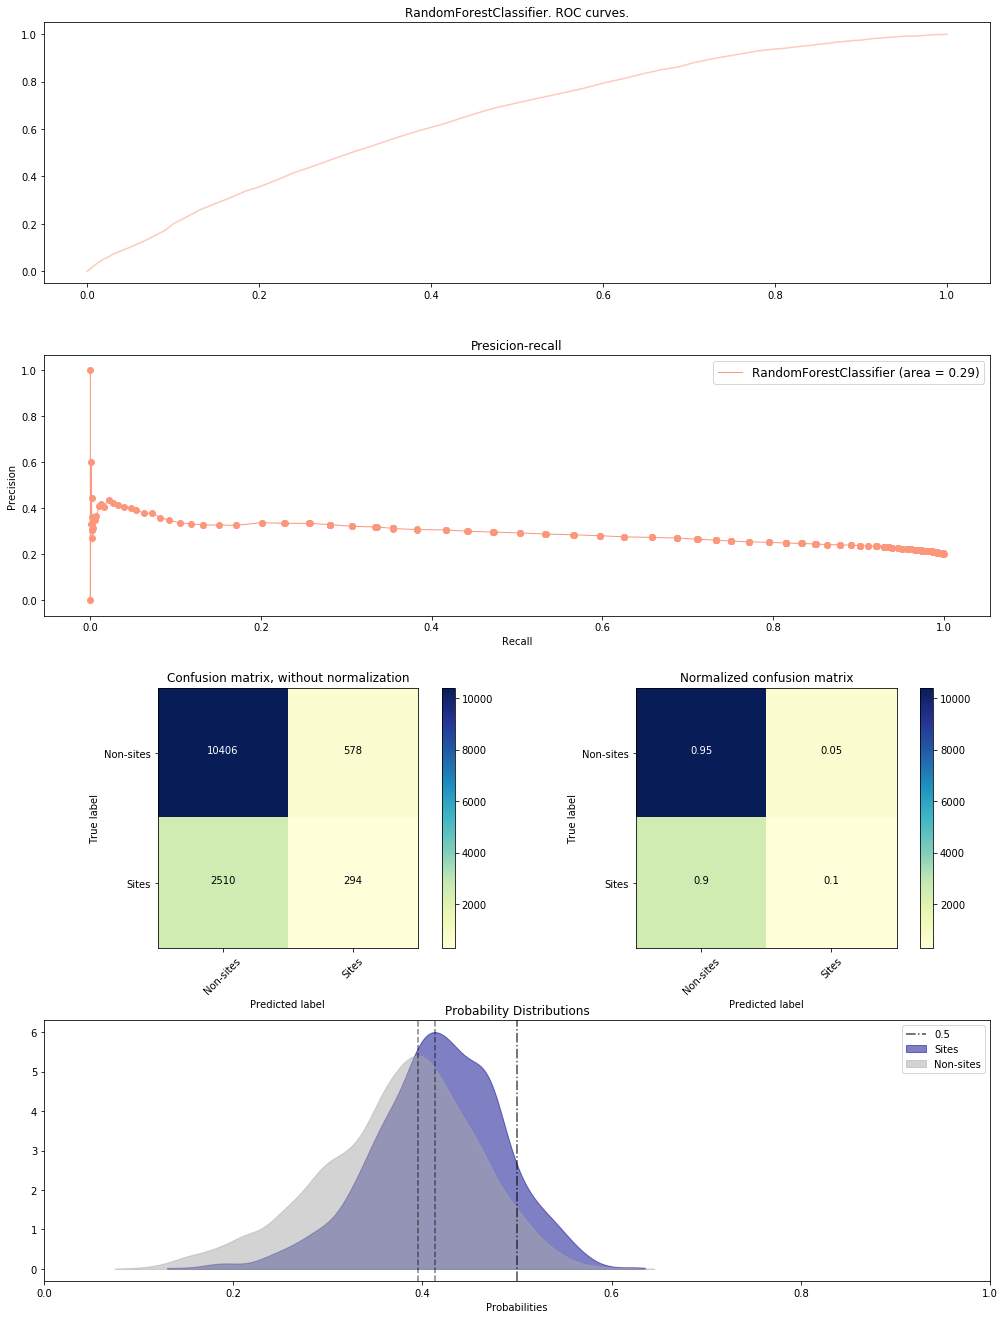

In [10]:
pdf_pages = PdfPages('outputs/with_groups/Predictions_A7_minresol_better_resolution.pdf')
data_ch = chosen_m.compute_validated(n_splits = 5)
pdf_pages.savefig()
pdf_pages.close()

#### Predict on test split of trainig data

Portion of sites in test:  0.124100933837
Portion of sites in train:  0.5


/usr/lib64/python3.4/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib64/python3.4/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


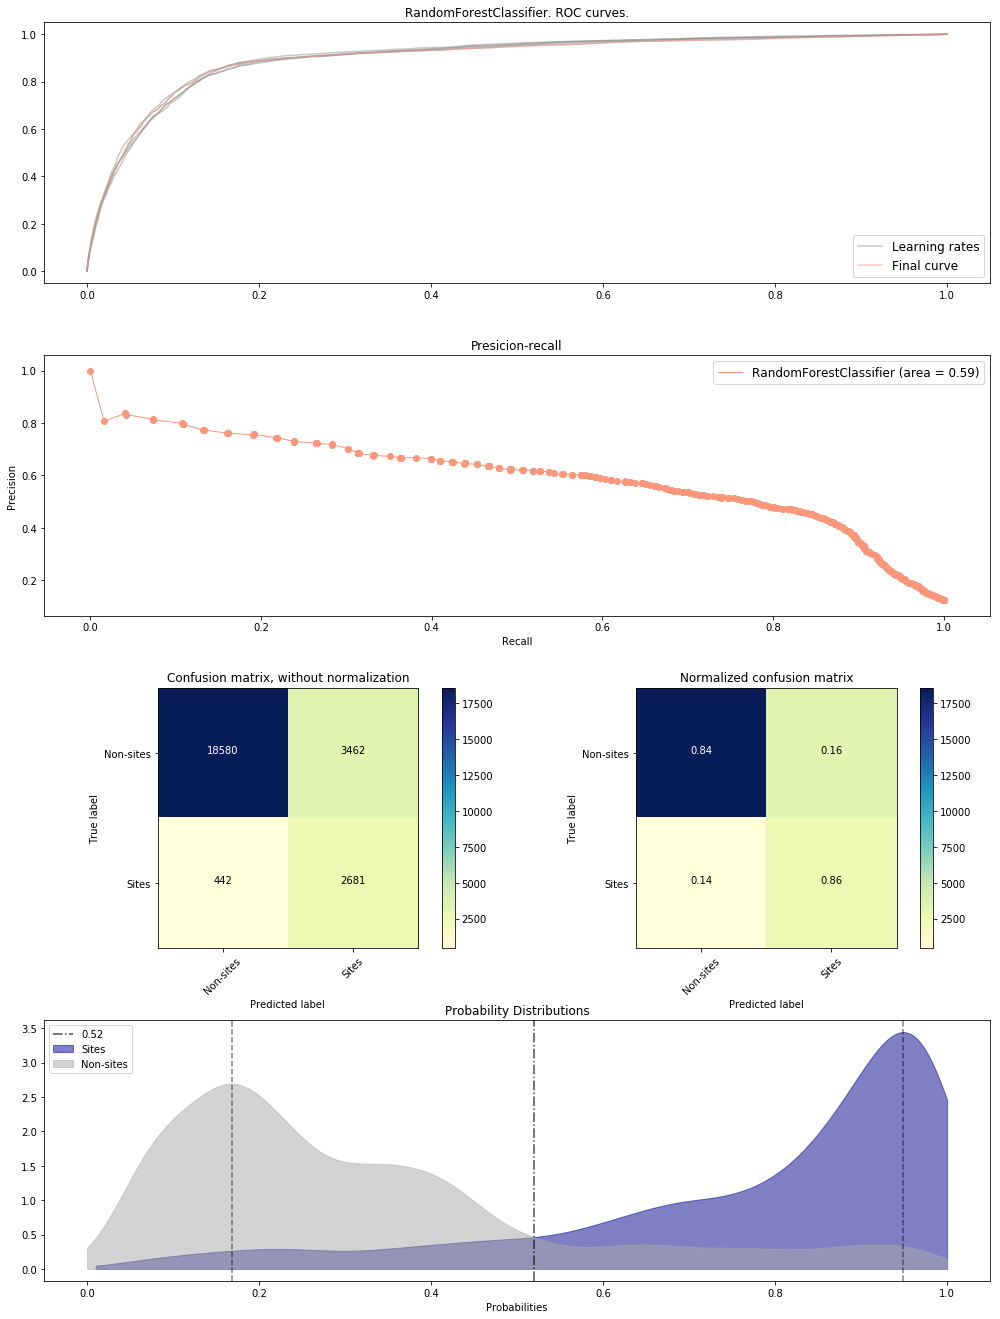

In [12]:
pdf_pages = PdfPages('outputs/with_groups/Predictions_A7_minresol_not_validated_with_better_resolution.pdf')
chosen_m.groups = chosen_m.data_numpy[:,:1]
data = chosen_m.compute(n_splits = 5)
pdf_pages.savefig()
pdf_pages.close()